In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCNN040.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCLN109.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCNN021.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCLN068.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCNN076.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCNN045.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCNN053.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCNN050.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCNN005.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCNN039.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCLN073.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCLN006.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/BSE_JSRT/JPCLN115.png
/kaggle/input/xray-bone-shadow-supression/BSE_JSRT/

In [2]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from glob import glob
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras.regularizers import Regularizer

2024-07-03 10:13:22.153086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 10:13:22.153194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 10:13:22.285808: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


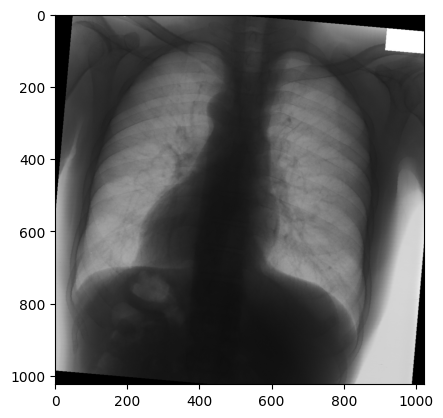

In [5]:
img='/kaggle/input/xray-bone-shadow-supression/augmented/augmented/source/6_5.png'
image=cv.imread(img)
plt.imshow(cv.imread(img))

In [4]:
def load_images_from_directory(path,target_size):
  images=[]
  for file in os.listdir(path):
    img=cv.imread(os.path.join(path,file))
    if img is not None:
      img=cv.resize(img,target_size)
      img=img.astype('float32')/255.0
      images.append(img)
    
  return np.array(images)

In [22]:
noisy_images_dir='/kaggle/input/xray-bone-shadow-supression/augmented/augmented/source'
denoised_images_dir='/kaggle/input/xray-bone-shadow-supression/augmented/augmented/target'

In [23]:
noisy_images = load_images_from_directory(noisy_images_dir, target_size=(224, 224))
denoised_images = load_images_from_directory(denoised_images_dir, target_size=(224, 224))

In [24]:
print(np.isnan(noisy_images).sum(),np.isinf(noisy_images).sum())
print(np.isnan(denoised_images).sum(),np.isinf(denoised_images).sum())

0 0
0 0


In [10]:
def kl_divergence(p, p_hat):
    p_hat = tf.clip_by_value(p_hat, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    
    return p * tf.math.log(p / p_hat) + (1 - p) * tf.math.log((1 - p_hat) / (1 - p))

In [11]:
class SparsityRegularizer(Regularizer):
    def __init__(self,sparsity_target=0.05,sparsity_penalty=1e-4):
        self.sparsity_target=sparsity_target
        self.sparsity_penalty=sparsity_penalty
    ## this method is invoked when regularizer is applied to a tensor
    def __call__(self,x):
        p_hat=tf.reduce_mean(x,axis=0)
        kl_div=kl_divergence(self.sparsity_target,p_hat)
        regularization=self.sparsity_penalty*tf.reduce_sum(kl_div)
        return regularization
        

    def get_config(self):
        return {'sparsity_target':self.sparsity_target,'sparsity_penalty':self.sparsity_penalty}
    
def sparse_activation(x,sparsity_target=0.05,sparsity_penalty=1e-4):
        regularizer=SparsityRegularizer(sparsity_target,sparsity_penalty)
        regularization=regularizer(x)
        return tf.nn.relu(x)-regularization

In [13]:
input_shape=(224,224,3)
sparsity_target = 0.05
sparsity_penalty = 1e-4


In [14]:
input_img = Input(shape=input_shape)



x=Conv2D(64,(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.l2(1e-4),activation='relu')(input_img)
x=BatchNormalization()(x)
x=Dropout(0.1)(x)
x=AvgPool2D((2,2),padding='same')(x)

x=Conv2D(128,(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.l2(1e-4),activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.1)(x)
x=AvgPool2D((2,2),padding='same')(x)

x=Conv2D(256,(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.l2(1e-4),activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.1)(x)
x=AvgPool2D((2,2),padding='same')(x)

x=Conv2D(512,(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
#x=Activation(lambda x:sparse_activation(x,sparsity_target,sparsity_penalty))(x)
x=BatchNormalization()(x)
x=Dropout(0.1)(x)
x=AvgPool2D((2,2),padding='same')(x)

x=Conv2D(1024,(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
#x=Activation(lambda x:sparse_activation(x,sparsity_target,sparsity_penalty))(x)
x=BatchNormalization()(x)
x=Dropout(0.1)(x)

encoded=AvgPool2D((2,2),padding='same')(x)


## add sparsity regularization to the encoded layer


## you need to create a custom loss class so that loss is added correctly during the compilation phase



## decoder layer
x=Conv2DTranspose(1024,(3,3),padding='same',activation='relu',strides=(2,2))(encoded)
x=BatchNormalization()(x)


x=Conv2DTranspose(512,(3,3),padding='same',activation='relu',strides=(2,2))(x)
x=BatchNormalization()(x)


x=Conv2DTranspose(256,(3,3),padding='same',activation='relu',strides=(2,2))(x)
x=BatchNormalization()(x)


x=Conv2DTranspose(128,(3,3),padding='same',activation='relu',strides=(2,2))(x)
x=BatchNormalization()(x)


x=Conv2DTranspose(64,(3,3),padding='same',activation='relu',strides=(2,2))(x)
x=BatchNormalization()(x)




output=Conv2D(input_shape[2],(3,3),activation='sigmoid',padding='same')(x)


model=Model(input_img,output)
model.summary()
  
  


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 112, 112, 64)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 56, 56, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 28, 28, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 14, 14, 512)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 1024)   │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 1024)   │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,994,243 (83.90 MB)

 Trainable params: 21,986,307 (83.87 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [15]:
def psnr(y_true, y_pred):
  max_pixel = 1.0
  mse = tf.reduce_mean(tf.square(y_true - y_pred))
  return 20 * tf.math.log(max_pixel / (tf.sqrt(mse) + tf.keras.backend.epsilon())) / tf.math.log(10.0)

In [16]:
def ssim_metric(y_true,y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true,y_pred,max_val=1.0))
## what tf.reduce_mean does is it takes average values of the tensor and returns a single value
## tf.image.ssim it will calculate ssim for individual pixels
## ssim metric value is in between 0-1

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger,TensorBoard
from tensorflow.keras.metrics import Recall,Precision,Accuracy
from tensorflow.keras.optimizers import Adam

In [18]:
if __name__ == "__main__":
    ##Seeding
    np.random.seed(42)
    tf.random.set_seed(42)

    metric=[psnr,ssim_metric]
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
    model.compile(loss='mean_squared_error',optimizer='adam',metrics=metric)
    #model.summary()

In [ ]:
history=model.fit(noisy_images,denoised_images,epochs=25,batch_size=32,shuffle=True,validation_split=0.1,callbacks=[early_stopping, reduce_lr])

In [ ]:
output=model.predict(noisy_images)

In [ ]:
plt.figure(figsize=(15,10))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(noisy_images[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source')

    ax = plt.subplot(3, 5, i+6)
    plt.imshow(output[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Predicted')
    
    ax = plt.subplot(3, 5, i+11)
    plt.imshow(denoised_images[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()